# Analysis Tutorial

This tutorial demonstrates how to analyze and interpret the outputs from Connectomemapper 3. In particular it will:

- Get the list of connectome files with [`pybids`](https://pypi.org/project/pybids/)
- Read the .tsv connectome files with [`networkx`](https://pypi.org/project/networkx/)
- Visualize with the plot functions of [`nilearn`](https://pypi.org/project/nilearn/) ([docs](https://nilearn.github.io/stable/index.html))
- Analyze with [`bctpy (Brain Connectivity Toolbox)`](https://pypi.org/project/bctpy/)

In [22]:
from bids import BIDSLayout
import networkx as nx
import pandas as pd
import nilearn
from nilearn import plotting
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
#from bctpy import algorithms
import datalad.api as dl
import scipy.io as sio

For demonstration, we are going to use an example dataset from [Open Neuro](https://openneuro.org/datasets/ds003505/versions/1.0.2) that already contains output from Connectomemapper.

In [23]:
# download example dataset with datalad
# uncomment next line once the new dataset is up
#vepcon_data = dl.install(path=os.path.join("..", "..", "example_data"),
#                         source="https://github.com/OpenNeuroDatasets/ds003505.git")

As the dataset is in [BIDS](https://bids.neuroimaging.io/), we can use [Pybids](https://bids-standard.github.io/pybids/) to help us load the data.

In [24]:
#layout = BIDSLayout(vepcon_data.path)
# add derivative folder containing the connectivity matrices
#layout.add_derivatives(os.path.join(vepcon_data.path, "derivatives", "cmp-v3.0.0-beta-RC1"))

In [25]:
#layout = BIDSLayout(vepcon_data.path)
path = os.path.join("/home", "localadmin", "data", "ds003505-sample")
layout = BIDSLayout(path)
# add derivative folder containing the connectivity matrices
#layout.add_derivatives(os.path.join(vepcon_data.path, "derivatives", "cmp-v3.0.0-beta-RC1"))
layout.add_derivatives(os.path.join(path, "derivatives", "cmp-v3.0.1"))

Now we can easily query for the filenames of the files we are interested in using `layout.get`. We will ask for the connectivity matrix of subject 01, scale 3, in tsv format. It will be returned as a list of file paths (in this case containing just one element).

In [26]:
conn_tsv_scale3 = layout.get(subject='01', extension='tsv',
                             suffix='connectivity', return_type='filename',
                             res='scale3')
conn_tsv_scale3

['/home/localadmin/data/ds003505-sample/derivatives/cmp-v3.0.1/sub-01/dwi/sub-01_atlas-L2018_res-scale3_conndata-network_connectivity.tsv']

We can then use [Pandas](https://pandas.pydata.org/) to read the file and display it as a table.

In [27]:
#edges = pd.read_csv(con_files[0], delimiter="\t")
edges = pd.read_csv(conn_tsv_scale3[0], delimiter="\t")
edges.head()

,source,target,number_of_fibers,fiber_length_mean,fiber_length_median,fiber_length_std,fiber_proportion,fiber_density,normalized_fiber_density,FA_mean,FA_std,FA_median,ADC_mean,ADC_std,ADC_median
0,1,1,578,6.577855,6.000000,2.086783,0.139558,0.024422,0.067457,0.190930,0.076994,0.176868,0.000787,0.000086,0.000775
1,1,3,254,9.507873,8.000008,4.339883,0.061328,0.007618,0.021041,0.184138,0.079206,0.172769,0.000801,0.000073,0.000799
2,1,9,101,10.198020,8.500000,4.645918,0.024386,0.003385,0.009351,0.258646,0.100590,0.252733,0.000780,0.000101,0.000756
3,1,2,98,7.704082,6.999998,2.756104,0.023662,0.003056,0.008441,0.247499,0.109299,0.247938,0.000815,0.000060,0.000812
4,1,113,59,10.203390,9.500001,3.235289,0.014245,0.002269,0.006268,0.243196,0.059146,0.241589,0.000858,0.000121,0.000855


Using [Networkx](https://networkx.org/documentation/stable/index.html), we can convert this table to a network graph. From that, we can convert individual measures to a [Numpy](https://numpy.org/) matrix. The matrix format is especially useful, as it allows us to plot the edge weights easily.

In [28]:
G = nx.from_pandas_edgelist(edges, edge_attr=True)
A_num_fibers = nx.to_numpy_matrix(G, weight="number_of_fibers")

Let's plot some of those adjacency matrices using [Matplotlib](https://matplotlib.org/) and [Seaborn](http://seaborn.pydata.org/index.html):

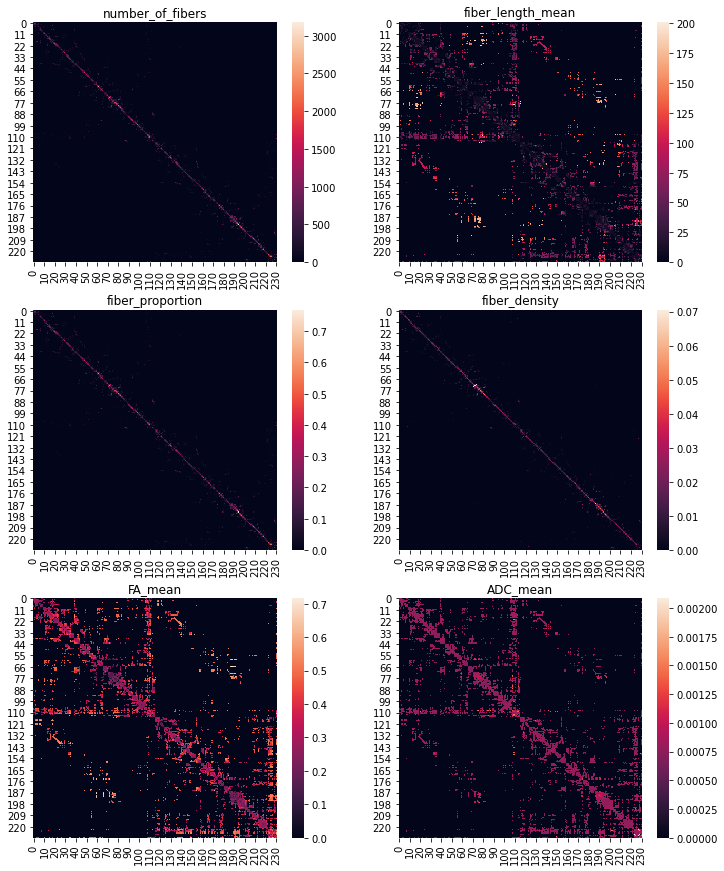

In [34]:
cols_to_plot = ["number_of_fibers", "fiber_length_mean",
                "fiber_proportion", "fiber_density",
                "FA_mean", "ADC_mean"]

fig, axs = plt.subplots(3,2, figsize=(12,15))
axs = axs.flatten()
for c, ax in zip(cols_to_plot, axs):
    A = nx.to_numpy_matrix(G, weight=c)
    sns.heatmap(A, ax=ax)
    ax.set_title(c)

Alternatively, we can also load the matrices in network format, by reading the gpickle files using Networkx:

In [30]:
conn_gpickle_scale3 = layout.get(subject='01', extension='gpickle',
                                 suffix='connectivity',
                                 return_type='filename',
                                 res='scale3')
G = nx.read_gpickle(conn_gpickle_scale3[0])  # same format as with tsv

...or load the .mat files with [Scipy](https://scipy.org/):

In [31]:
conn_mat_scale3 = layout.get(subject='01', extension='mat',
                             suffix='connectivity', return_type='filename',
                             res='scale3')
A_mat = sio.loadmat(conn_mat_scale3[0])

The adjacency matrices here can be accessed like this:

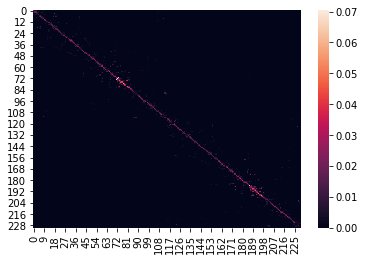

In [50]:
sns.heatmap(A_mat["sc"]["fiber_density"][0][0])
plt.show()

In [33]:
#parcellation_path = os.path.join(path, "code",
#                                 "sub-colin27_T1w_parc_scale1.nii.gz")
parcellation_path = os.path.join(path_hcp, "sub-100307_atlas-L2018_res-scale1_dseg.nii.gz")
coords, labels = plotting.find_parcellation_cut_coords(parcellation_path, return_label_names=True)

NameError: name 'path_hcp' is not defined

In [ ]:
coords_df = pd.DataFrame(coords, columns=["x","y","z"])
coords_df.to_csv("coords.csv")

In [ ]:
A = nx.to_numpy_matrix(G, weight="fiber_density")

In [ ]:
plotting.plot_connectome(np.array(A), coords)